In [2]:
library("ggplot2")
library("clusterCrit")
source("runfactorization.R")

# Parameters for the plots
dot_size <- 1.5
dot_alpha <- 1.0
xlabel <- "Factor 1"
ylabel <- "Factor 2"

# Load annotations from the metadata
sample_annot <- metadata[, c("sample.rna", "celltype")]

# Folder for results
results_folder <- "../results_single_cell/"
# Create output folder
dir.create(results_folder, showWarnings = FALSE)

# Run factorization methods
out <- runfactorization("../data/single-cell/",
                        c("CellLines_RNAseqCounts.txt", "CellLines_ATACseqCounts.txt"),
                        2, 
                        sep="\t", 
                        filtering="stringent")

c_index <- numeric(0)

# For each factorization method
for(i in 1:length(out$factorizations)){
    
    # Get factorization result
    factors <- out$factorizations[[i]][[1]]

    # Delete NAs
    factors <- factors[!is.na(factors[,1]) & !is.na(factors[,2]), ]
    sample_annot <- sample_annot[!is.na(sample_annot[,1]) & !is.na(sample_annot[,2]), ]

    # Data to be plotted
    df <- data.frame(x =  factors[,1], y = factors[,2], color_by = sample_annot[,2])
    # Plot results
    p <- ggplot(df, aes_string(x = "x", y = "y")) + 
       geom_point(aes_string(color = "color_by"), size=dot_size, alpha=dot_alpha) + 
       xlab(xlabel) + ylab(ylabel) +
       # scale_shape_manual(values=c(19,1,2:18)[seq_along(unique(shape_by))]) +
       theme(plot.margin = margin(20, 20, 10, 10), 
             axis.text = element_text(size = rel(1), color = "black"), 
             axis.title = element_text(size = 16), 
             axis.title.y = element_text(size = rel(1.1), margin = margin(0, 10, 0, 0)), 
             axis.title.x = element_text(size = rel(1.1), margin = margin(10, 0, 0, 0)), 
             axis.line = element_line(color = "black", size = 0.5), 
             axis.ticks = element_line(color = "black", size = 0.5),
             panel.border = element_blank(), 
             panel.grid.major = element_blank(),
             panel.grid.minor = element_blank(), 
             panel.background = element_blank(),
             legend.key = element_rect(fill = "white"),
             legend.text = element_text(size = 16),
             legend.title = element_text(size =16)
       )
    p + scale_color_manual(values=c("#0072B2", "#D55E00", "#CC79A7"))
    # Export plot as JPEG image
    ggsave(paste0(results_folder, "plot_",out$method[i],".jpg"))

    # Encode cell type annotations by numeric codes
    ann <- factor(sample_annot[,2], levels=c("HCT", "Hela", "K562"))
    ann <- as.integer(ann)
    # Compare factors and annotations
    c_index <- c(c_index, intCriteria(factors, as.integer(ann), crit=c("C_index"))$c_index)

}

# Build output table
report_cindex <- data.frame(method=out$method, cindex=c_index)

# Export results as one tab-separated table
write.table(report_cindex, file = paste0(results_folder, "singlecell_cindex.txt"), 
            sep="\t", col.names=FALSE, row.names=FALSE, quote=FALSE)

Loading required package: MASS

Loading required package: NMF

Loading required package: pkgmaker

Loading required package: registry

Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 27/28

  To enable shared memory capabilities, try: install.extras('
NMF
')

Loading required package: mclust

Package 'mclust' version 5.4.6
Type 'citation("mclust")' for citing this R package in publications.

Loading required package: InterSIM

Loading required package: tools

Loading required package: ade4


Attaching package: ‘ade4’


The following object is masked from ‘package:BiocGenerics’:

    score



Attaching package: ‘GPArotation’


The following object is masked from ‘package:NMF’:

    entropy



Attaching package: ‘MOFAtools’


The following objects are masked from ‘package:NMF’:

    featureNames, featureNames<-, predict, sampleNames, sampleNames<-


The following objects are masked f

ERROR: Error in eval(expr, envir, enclos): 找不到对象'metadata'


In [9]:
##### runfactoization runs all the considered multi-omics factorization
### the required inputs are:
### "folder" corresponding to the path to the folder where the input files are contained, in the idea that all omics matrices are organized inside a unique folder
### "file.names" corresponding to a vector containing the names of all the omics files
### "num.factors" containing the number of factors in which we desire to decompose the matrices
### "sep=" "" corresponding to the separator used in the omics files required to properly read them
### "single.cell" indicating if the data are single cell data. In this case the filtering of the data will be more intense in respect to other data types
### "filtering"

### the input files need to be log2 transformed before running the analysis


library("RGCCA")
library("r.jive")
library("IntNMF")
library("omicade4")
library("MSFA")
library("GPArotation")
library("MOFAtools")
library("tensorBSS")
source("tICA.R")
library("iCluster")

testrunfactorization <- function(folder,file.names,num.factors,sep=" ",filtering="none"){
  factorizations<-list()
  t<-1
  method<-numeric(0)
  
  num.factors<-as.numeric(num.factors)

  
  ##creating list of omics
  omics <- list()
  for(i in 1:length(file.names)){
    omics[[i]]<-as.matrix(read.table(paste(folder,file.names[i],sep="/"),sep=sep,row.names=1,header=T))
  }
  
  ####
  #omics<-lapply(omics, function(x) t(x))
  ######
  
  ##restricting to common samples and filtering
  samples<-colnames(omics[[1]])
  for(j in 1:length(omics)){
    samples<-intersect(samples,colnames(omics[[j]]))
  }
  for(j in 1:length(omics)){
    omics[[j]]<-omics[[j]][,samples]
    if(filtering!="none"){
      x<-apply( omics[[j]],1,sd)
      x<-as.matrix(sort(x, decreasing = T))
      w<-which(x>0)
      if(filtering=="stringent"){
        selected<-rownames(x)[1:min(w[length(w)],5000)]
      }else{
        selected<-rownames(x)[1:min(w[length(w)],6000)]
      }
      m<-match(rownames(omics[[j]]),selected)
      w<-which(!is.na(m))
      omics[[j]]<-omics[[j]][w,]
    }else{
      omics[[j]]<-omics[[j]][which(apply(omics[[j]],2,sd)>0),]
    }
  }  
  write.table(omics, file = "omics.txt", 
            sep="\t", col.names=FALSE, row.names=FALSE, quote=FALSE)

 
  ##RGCCA 
  factorizations_RGCCA<-rgcca(lapply(omics, function(x) t(x)), ncomp = rep(num.factors, length(omics)), scheme = "centroid", scale = TRUE, init = "svd",bias = TRUE, tol = 1e-08, verbose = F)
  factors_rgcca<-as.matrix(factorizations_RGCCA$Y[[1]])
  metagenes_rgcca <- list()
  for(j in 1:length(omics)){
    metagenes_rgcca[[j]]<-as.matrix(factorizations_RGCCA$a[[j]])
    rownames(metagenes_rgcca[[j]])<-rownames(omics[[j]])
    colnames(metagenes_rgcca[[j]])<-1:num.factors
  }
  factorizations[[t]]<-list(factors_rgcca,metagenes_rgcca)
  t<-t+1
  method<-c(method,"RGCCA")
  
#   ###MCIA
#   omics_pos<-list()
#   for(j in 1:length(omics)){
#     if(min(omics[[j]])<0){
#       omics_pos[[j]]<-omics[[j]]+abs(min(omics[[j]]))
#     }else{
#       omics_pos[[j]]<-omics[[j]]
#     }
#     omics_pos[[j]]<-omics_pos[[j]]/max(omics_pos[[j]])
#   }
#   factorizations_mcia<-mcia(omics_pos, cia.nf = num.factors)
#   factors_mcia<-as.matrix(factorizations_mcia$mcoa$SynVar)
#   metagenes_mcia<-list()
#   for(j in 1:length(omics)){
#     metagenes_mcia[[j]]<-as.matrix(factorizations_mcia$mcoa$axis[1:dim(omics[[j]])[1],])
#     rownames(metagenes_mcia[[j]])<-rownames(omics[[j]])
#     colnames(metagenes_mcia[[j]])<-1:num.factors
#   }
#   factorizations[[t]]<-list(factors_mcia,metagenes_mcia)
#   t<-t+1
#   method<-c(method,"MCIA")
  
#   ###MOFA
#   MOFAobject <- createMOFAobject(omics)
#   DataOptions <- getDefaultDataOptions()
#   ModelOptions <- getDefaultModelOptions(MOFAobject)
#   ModelOptions$numFactors <- num.factors
#   TrainOptions <- getDefaultTrainOptions()
  
#   MOFAobject <- prepareMOFA(
#     MOFAobject,
#     DataOptions = DataOptions,
#     ModelOptions = ModelOptions,
#     TrainOptions = TrainOptions
#   )
#   MOFAobject <- runMOFA(MOFAobject)
#   metagenes_mofa <- getWeights(
#     MOFAobject
#   )
  
#   factors_mofa <- getFactors(
#     MOFAobject
#   )
#   factorizations[[t]]<-list(factors_mofa,metagenes_mofa)
#   t<-t+1
#   method<-c(method,"MOFA")
  
#   # # ###MSFA
#   # if(filtering=="none" ||  filtering=="stringent"){
#   # start_value <- start_msfa(X_s = omics_pos, k = num.factors, j_s = c(num.factors,num.factors,num.factors))
#   # mle <-  ecm_msfa(omics_pos, start_value, trace = FALSE)
#   # factors_msfa<-as.matrix(mle$Phi)
#   # rownames(factors)<-colnames(omics[[1]])
#   # colnames(factors)<-1:num.factors
#   # metagenes_msfa<-list()
#   # for(j in 1:length(omics)){
#   #    metagenes_msfa[[j]]<-t(omics[[j]]) %*% solve(cor(t(omics[[j]]))) %*% factors_msfa
#   #    rownames(metagenes_msfa[[j]])<-rownames(omics[[j]])
#   #    colnames(metagenes_msfa[[j]])<-1:num.factors
#   #  }
#   #  factorizations[[t]]<-list(factors_msfa,metagenes_msfa)
#   #  t<-t+1
#   # method<-c(method,"MSFA")
#   # }
  
#   ###iCluster
#   factorizations_icluster<-iCluster2(lapply(omics, function(x) t(x)), k=num.factors+1)
#   factors_icluster<-as.matrix(t(factorizations_icluster$expZ))
#   metagenes_icluster<-list()
#   for(j in 1:length(omics)){
#     metagenes_icluster[[j]]<-as.matrix(factorizations_icluster$W[1:dim(omics[[j]])[1],])
#     rownames(metagenes_icluster[[j]])<-rownames(omics[[j]])
#     colnames(metagenes_icluster[[j]])<-1:num.factors
#   }
#   factorizations[[t]]<-list(factors_icluster,metagenes_icluster)
#   t<-t+1
#   method<-c(method,"iCluster")
  
#   ###intNMF
#   factorizations_intnmf<-nmf.mnnals(dat=lapply(omics_pos, function(x) t(x)), k=num.factors)
#   factors_intNMF<-as.matrix(factorizations_intnmf$W)
#   colnames(factors_intNMF)<-1:num.factors
#   metagenes_intNMF<-list()
#   for(j in 1:length(omics)){
#     metagenes_intNMF[[j]]<-t(factorizations_intnmf$H[[j]]) 
#     rownames(metagenes_intNMF[[j]])<-rownames(omics[[j]])
#     colnames(metagenes_intNMF[[j]])<-1:num.factors
#   }
#   factorizations[[t]]<-list(factors_intNMF,metagenes_intNMF)
#   t<-t+1
#   method<-c(method,"intNMF")
  
  
#   ### JIVE
#   factorizations_jive<-jive(omics, rankJ=num.factors, rankA = rep(num.factors, length(omics)), method = "given", conv = "default", maxiter = 100, showProgress=FALSE)
#   rankJV <- factorizations_jive$rankJ;
#   rankIV.v <- factorizations_jive$rankA;
#   J<-numeric(0)
#   ng<-0
#   metagenes_jive <- list();
#   for(j in 1:length(omics)){
#     J <- rbind(J,factorizations_jive$joint[[j]]);
#     ng<-c(ng,dim(factorizations_jive$joint[[j]])[1])
#   }
#   svd.o <- svd(J);
#   jV <- svd.o$v %*% diag(svd.o$d);
#   for(j in 1:length(omics)){
#     metagenes_jive[[j]] <- svd.o$u[(1+sum(ng[1:j])):sum(ng[1:j+1]),1:rankJV]; ###error in dimension
#     rownames(metagenes_jive[[j]])<-rownames(omics[[j]])
#     colnames(metagenes_jive[[j]])<-1:num.factors
#   }
#   factors_jive=jV[,1:rankJV]
#   rownames(factors_jive)<-colnames(omics[[1]])
#   colnames(factors_jive)<-1:num.factors
#   factorizations[[t]]<-list(factors_jive,metagenes_jive)
#   t<-t+1
#   method<-c(method,"JIVE")
  

  

  


  

  
#   ###tICA
#     omics_tensor<-list()
#     for(j in 1:length(omics)){
#       omics_tensor[[j]]<-cor(omics[[j]], method = "spearman")
#     }
    
#     S<-vector(length = dim(omics[[1]])[2]*dim(omics[[1]])[2]*length(omics))
#     dim(S) <- c(length(omics), dim(omics[[1]])[2], dim(omics[[1]])[2])
#     for(j in 1:length(omics)){
#       S[j,,]<-t(omics_tensor[[j]])
#     }
#     tICA<-DoTICA(S,num.factors,method="FOBI")
#     factors_tica<-as.matrix(tICA$signals)
#     rownames(factors_tica)<-colnames(omics[[1]])
#     metagenes_tica<-list()
#     for(j in 1:length(omics)){
#       metagenes_tica[[j]]<-omics[[j]] %*% ginv(t(tICA$signals))
#       rownames(metagenes_tica[[j]])<-rownames(omics[[j]])
#       colnames(metagenes_tica[[j]])<-1:num.factors
#     }
#     factorizations[[t]]<-list(factors_tica,metagenes_tica)
#     t<-t+1
#     method<-c(method,"tICA")


  


  
#   # ###scikit-fusion
#   system("mkdir ../data/scikit/")
#   temp.folder<-'../data/scikit/'
#   files<-""
#   for(j in 1:length(omics)){
#     write.table(omics[[j]],paste(temp.folder,"/omics",j,".txt",sep=""),sep=" ",col.names=T, row.names=T)
#     files<-paste(files,paste("omics",j,".txt",sep=""),sep=" ")
#   }
#   system(paste("python ./scikit_fusion.py", "'../data/scikit/'","'../data/scikit/'",num.factors,"' '",files,sep=" "))
#   factors_scikit<-as.matrix(read.table(paste(temp.folder,"signals.txt",sep=""),sep="\t",header=F))
#   colnames(factors_scikit)<-1:num.factors
#   rownames(factors_scikit)<-colnames(omics[[1]])
#   metagenes_scikit<-list()
#   for(j in 1:length(omics)){
#     metagenes_scikit[[j]]<-as.matrix(read.table(paste(temp.folder,"projomics",j,".txt",sep=""),sep="\t",header=F))
#     rownames(metagenes_scikit[[j]])<-rownames(omics[[j]])
#     colnames(metagenes_scikit[[j]])<-1:num.factors
#   }
#   factorizations[[t]]<-list(factors_scikit,metagenes_scikit)
#   t<-t+1
#   method<-c(method,"scikit-fusion")
#   system("rm -r ../data/scikit/")
  
  
  out<-list(factorizations=factorizations,method=method)
  
  return(out)
}


In [10]:
out <- testrunfactorization("../data/single-cell/",
                        c("CellLines_RNAseqCounts.txt", "CellLines_ATACseqCounts.txt"),
                        2, 
                        sep="\t", 
                        filtering="stringent")

In [6]:
out

$factorizations
$factorizations[[1]]
$factorizations[[1]][[1]]
                               comp1       comp2
HCT_CL100049490_L01_10  -0.603619302 -0.23299647
HCT_CL100049490_L01_14  -0.632492584 -0.18841422
HCT_CL100049490_L01_15  -0.758610238 -0.19184096
HCT_CL100049490_L01_16  -0.369532528 -0.25537424
HCT_CL100049490_L01_19  -0.798700859 -0.16130432
HCT_CL100049490_L01_2   -0.778697261 -0.18424769
HCT_CL100049490_L01_21  -0.680400157 -0.20631098
HCT_CL100049490_L01_22  -0.910482370 -0.11923025
HCT_CL100049490_L01_24  -0.660502514 -0.20125706
HCT_CL100049490_L01_27  -0.677422847 -0.21397578
HCT_CL100049490_L01_28   0.043902569 -0.34706599
HCT_CL100049490_L01_29   0.022682913 -0.37592705
HCT_CL100049490_L01_3   -0.630363953 -0.21604406
HCT_CL100049490_L01_34  -0.631909751 -0.18566653
HCT_CL100049490_L01_35   0.008799254 -0.36012154
HCT_CL100049490_L01_37  -0.144011648 -0.31343291
HCT_CL100049490_L01_38  -0.748957989 -0.20644185
HCT_CL100049490_L01_39  -0.518834437 -0.25258825
HCT_CL100049490_L01_4   -0.185956750 -0.28376007
HCT_CL100049490_L01_44  -0.354688160 -0.26443864
HCT_CL100049490_L01_45  -0.047822974 -0.34554671
HCT_CL100049490_L01_48  -0.853088112 -0.13941892
HCT_CL100049490_L01_7   -0.539051277 -0.22594812
HCT_CL100049490_L02_49   0.677212516 -0.37452671
HCT_CL100049490_L02_52  -0.253533343 -0.29024933
HCT_CL100049490_L02_53   0.396343303 -0.35399847
HCT_CL100049490_L02_54  -0.681967479 -0.21308273
HCT_CL100049490_L02_55  -0.451779929 -0.24281442
HCT_CL100049490_L02_59  -0.554110697 -0.26174437
HCT_CL100049490_L02_61  -0.540449915 -0.24028395
HCT_CL100049490_L02_69  -0.528365611 -0.25067656
HCT_CL100049490_L02_70  -0.933989506 -0.11425298
HCT_CL100049490_L02_75  -0.114795630 -0.29214532
HCT_CL100049490_L02_78  -0.353538850 -0.27549622
HCT_CL100049490_L02_79  -0.491618313 -0.25384516
HCT_CL100049490_L02_83   0.123365683 -0.36527309
HCT_CL100049490_L02_84  -0.363698216 -0.27907964
HCT_CL100049490_L02_85  -0.587617574 -0.24180205
HCT_CL100049490_L02_86  -0.441282037 -0.26996009
HCT_CL100049490_L02_88  -0.505212912 -0.23463262
HCT_CL100049490_L02_91  -0.287905154 -0.29445835
HCT_CL100049490_L02_93  -0.744295495 -0.18670130
HCT_CL100036542_L01_10  -0.293727055 -0.26439315
HCT_CL100036542_L01_12  -0.096013345 -0.29976954
HCT_CL100036542_L01_13  -0.603391426 -0.25074031
HCT_CL100036542_L01_14  -0.453851433 -0.27068136
HCT_CL100036542_L01_15  -0.679335325 -0.20893975
HCT_CL100036542_L01_19   0.625119529 -0.39613794
HCT_CL100036542_L01_2   -0.655525604 -0.21274655
HCT_CL100036542_L01_21  -0.763036626 -0.16238498
HCT_CL100036542_L01_22  -0.602825205 -0.23404071
HCT_CL100036542_L01_23  -0.046735916 -0.32532242
HCT_CL100036542_L01_24  -0.569138020 -0.21904110
HCT_CL100036542_L01_3   -0.251909393 -0.29586972
HCT_CL100036542_L01_32  -0.838591205 -0.16112146
HCT_CL100036542_L01_36  -0.420832139 -0.25939086
HCT_CL100036542_L01_37  -0.388382352 -0.26150250
HCT_CL100036542_L01_42  -0.327029503 -0.26339438
HCT_CL100036542_L01_43  -0.820165234 -0.14797903
HCT_CL100036542_L01_44   0.802107510 -0.39149810
HCT_CL100036542_L01_45  -0.362793738 -0.30384807
HCT_CL100036542_L01_47  -0.304463132 -0.31265526
HCT_CL100036542_L01_48  -0.678657869 -0.17884508
HCT_CL100036542_L01_5   -0.481758755 -0.25125417
HCT_CL100036542_L01_7   -0.179458435 -0.31219395
HCT_CL100036542_L01_9   -0.417621997 -0.24939892
HCT_CL100036542_L02_51  -0.802718458 -0.16896733
HCT_CL100036542_L02_52  -0.191642225 -0.29034991
HCT_CL100036542_L02_53  -0.320693034 -0.24791289
HCT_CL100036542_L02_54   0.008178763 -0.35971215
HCT_CL100036542_L02_55  -0.183979901 -0.32476182
HCT_CL100036542_L02_56  -0.837174626 -0.16714775
HCT_CL100036542_L02_59  -0.241203283 -0.32457710
HCT_CL100036542_L02_62  -0.442837240 -0.24784930
HCT_CL100036542_L02_63  -0.172892304 -0.30687859
HCT_CL100036542_L02_64  -0.739486347 -0.16386409
HCT_CL100036542_L02_66  -0.480608246 -0.23421518
HCT_CL100036542_L02_67  -0.343126914 -0.28862647
HCT_CL100036542_L02_69  -0.439633925 -0.24935155
HCT_CL100036542_L

In [2]:
# Load metadata
metadata<-readRDS("../data/single-cell/CellLines_metadata.RDS", refhook = NULL)

In [4]:
print(metadata[, c("celltype")])

  [1] "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT" 
 [11] "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT" 
 [21] "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT" 
 [31] "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT" 
 [41] "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT" 
 [51] "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT" 
 [61] "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT" 
 [71] "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT" 
 [81] "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT"  "HCT" 
 [91] "Hela" "Hela" "Hela" "Hela" "Hela" "Hela" "Hela" "Hela" "Hela" "Hela"
[101] "Hela" "Hela" "Hela" "Hela" "Hela" "Hela" "Hela" "Hela" "Hela" "Hela"
[111] "Hela" "Hela" "Hela" "Hela" "Hela" "Hela" "Hela" "Hela" "Hela" "Hela"
[121] "Hela" "Hela" "Hela" "Hela" "Hela" "Hela" "Hela" "Hela" "Hela" "Hela"
[131] "Hela"

In [5]:
write.table(metadata[, c("celltype")], "celltype.txt", sep="\t", row.names=FALSE, col.names=FALSE)

In [1]:
factorization=read.table("../data/single-cell/AE_FAETC_EM.txt", sep=" ", header=FALSE)

library("ggplot2")
library("clusterCrit")
#source("runfactorization.R")

# Parameters for the plots
dot_size <- 1.5
dot_alpha <- 1.0
xlabel <- "Factor 1"
ylabel <- "Factor 2"

# Load annotations from the metadata
sample_annot <- metadata[, c("sample.rna", "celltype")]

# Folder for results
results_folder <- "../results_single_cell_AE_FAETC_EM/"
# Create output folder
dir.create(results_folder, showWarnings = FALSE)

c_index <- numeric(0)

# Get factorization result
factors <- factorization

# Delete NAs
factors <- factors[!is.na(factors[,1]) & !is.na(factors[,2]), ]
sample_annot <- sample_annot[!is.na(sample_annot[,1]) & !is.na(sample_annot[,2]), ]

# Data to be plotted
df <- data.frame(x =  factors[,1], y = factors[,2], color_by = sample_annot[,2])
# Plot results
p <- ggplot(df, aes_string(x = "x", y = "y")) + 
   geom_point(aes_string(color = "color_by"), size=dot_size, alpha=dot_alpha) + 
   xlab(xlabel) + ylab(ylabel) +
   # scale_shape_manual(values=c(19,1,2:18)[seq_along(unique(shape_by))]) +
   theme(plot.margin = margin(20, 20, 10, 10), 
         axis.text = element_text(size = rel(1), color = "black"), 
         axis.title = element_text(size = 16), 
         axis.title.y = element_text(size = rel(1.1), margin = margin(0, 10, 0, 0)), 
         axis.title.x = element_text(size = rel(1.1), margin = margin(10, 0, 0, 0)), 
         axis.line = element_line(color = "black", size = 0.5), 
         axis.ticks = element_line(color = "black", size = 0.5),
         panel.border = element_blank(), 
         panel.grid.major = element_blank(),
         panel.grid.minor = element_blank(), 
         panel.background = element_blank(),
         legend.key = element_rect(fill = "white"),
         legend.text = element_text(size = 16),
         legend.title = element_text(size =16)
   )
p + scale_color_manual(values=c("#0072B2", "#D55E00", "#CC79A7"))
# Export plot as JPEG image
ggsave(paste0(results_folder, "plot_","AE_FAETC_EM",".jpg"))

# Encode cell type annotations by numeric codes
ann <- factor(sample_annot[,2], levels=c("HCT", "Hela", "K562"))
ann <- as.integer(ann)
# print(ann)
# print(factors)
# Compare factors and annotations
c_index <- c(c_index, intCriteria(as.matrix(factors), as.integer(ann), crit=c("C_index"))$c_index)
print(c_index)
# Build output table
report_cindex <- data.frame(method="AE_FAETC_EM", cindex=c_index)
print(report_cindex)
# Export results as one tab-separated table
write.table(report_cindex, file = paste0(results_folder, "singlecell_cindex_AE_FAETC_EM.txt"), 
            sep="\t", col.names=FALSE, row.names=FALSE, quote=FALSE)

ERROR: Error in eval(expr, envir, enclos): 找不到对象'metadata'


In [ ]:
library("clusterCrit")
factorization=read.table("../data/simulations/equal/5/AE_FAETC_EM_5.txt", sep=" ", header=FALSE)
factors=factorization
#print(factorization)
ann=read.table("../data/simulations/equal/5/c.txt", sep="", header=FALSE)
ann <- factor(ann, levels=c(0,1,2,3,4))

print(ann)
c_index <- numeric(0)
c_index <- c(c_index, intCriteria(as.matrix(factors),as.integer(ann), crit=c("C_index"))$c_index)
print(c_index)

             V1          V2          V3         V4          V5
1    4.61019325  5.16947794 -3.76821876  5.0370860  -9.9737577
2   -0.56126964  5.01752853 -2.33453012 -0.8252841  -0.4528220
3    0.88768262  3.87528944  0.96259248 -4.0607824  -3.9274344
4    5.92709112  1.79780912 -0.30577454  2.2509692   0.8909727
5   -1.59644318  6.16670990 -2.62944984 -0.8999423  -0.7932591
6    0.27649751  4.16627407 -1.68425679 -0.8543711  -0.7703041
7    0.68484432  4.02045870  1.12220144 -3.4713376  -3.9866064
8    0.99768144  3.69249868  1.16467333 -3.6697772  -3.9355514
9    5.85494089  1.22425675 -0.01612791  1.8666883   0.8808652
10  -0.14798826  3.76603556 -1.59501779 -1.0284584  -0.5151181
11   3.14144683  2.99328661 -1.17072058  4.5182977 -10.6349373
12   3.30559206  3.42356443 -1.64794075  5.1160250 -10.1963148
13   0.38587579  4.17554712  1.56078017 -3.4791327  -4.1053753
14  -0.92032236  4.71401119 -2.13506413 -0.9182727  -0.4636051
15   9.40060616  0.69357455 -0.17047414  1.8089135   0.

Saving 6.67 x 6.67 in image



  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[112] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[186] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3


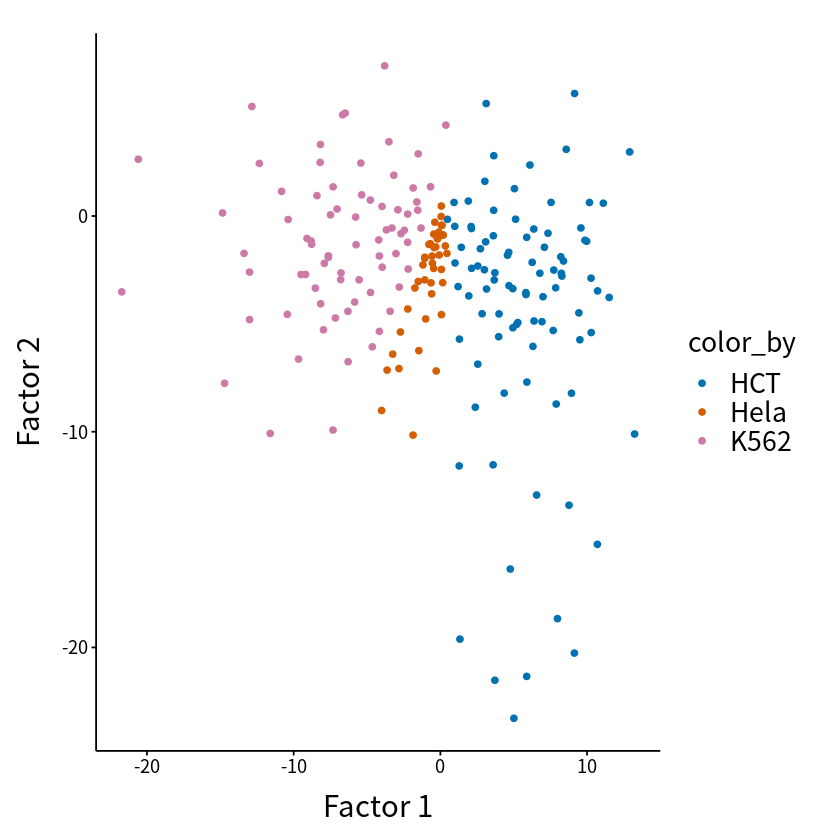

In [19]:
factorization=read.table("../data/single-cell/AE_FCTAE_EM.txt", sep=" ", header=FALSE)

library("ggplot2")
library("clusterCrit")
#source("runfactorization.R")

# Parameters for the plots
dot_size <- 1.5
dot_alpha <- 1.0
xlabel <- "Factor 1"
ylabel <- "Factor 2"

# Load annotations from the metadata
sample_annot <- metadata[, c("sample.rna", "celltype")]

# Folder for results
results_folder <- "../results_single_cell_AE_FCTAE_EM/"
# Create output folder
dir.create(results_folder, showWarnings = FALSE)

c_index <- numeric(0)

# Get factorization result
factors <- factorization

# Delete NAs
factors <- factors[!is.na(factors[,1]) & !is.na(factors[,2]), ]
sample_annot <- sample_annot[!is.na(sample_annot[,1]) & !is.na(sample_annot[,2]), ]

# Data to be plotted
df <- data.frame(x =  factors[,1], y = factors[,2], color_by = sample_annot[,2])
# Plot results
p <- ggplot(df, aes_string(x = "x", y = "y")) + 
   geom_point(aes_string(color = "color_by"), size=dot_size, alpha=dot_alpha) + 
   xlab(xlabel) + ylab(ylabel) +
   # scale_shape_manual(values=c(19,1,2:18)[seq_along(unique(shape_by))]) +
   theme(plot.margin = margin(20, 20, 10, 10), 
         axis.text = element_text(size = rel(1), color = "black"), 
         axis.title = element_text(size = 16), 
         axis.title.y = element_text(size = rel(1.1), margin = margin(0, 10, 0, 0)), 
         axis.title.x = element_text(size = rel(1.1), margin = margin(10, 0, 0, 0)), 
         axis.line = element_line(color = "black", size = 0.5), 
         axis.ticks = element_line(color = "black", size = 0.5),
         panel.border = element_blank(), 
         panel.grid.major = element_blank(),
         panel.grid.minor = element_blank(), 
         panel.background = element_blank(),
         legend.key = element_rect(fill = "white"),
         legend.text = element_text(size = 16),
         legend.title = element_text(size =16)
   )
p + scale_color_manual(values=c("#0072B2", "#D55E00", "#CC79A7"))
# Export plot as JPEG image
ggsave(paste0(results_folder, "plot_","AE_FCTAE_EM",".jpg"))

# Encode cell type annotations by numeric codes
ann <- factor(sample_annot[,2], levels=c("HCT", "Hela", "K562"))
ann <- as.integer(ann)
print(ann)
# Compare factors and annotations
c_index <- c(c_index, intCriteria(as.matrix(factors), as.integer(ann), crit=c("C_index"))$c_index)

# Build output table
report_cindex <- data.frame(method="AE_FCTAE_EM", cindex=c_index)

# Export results as one tab-separated table
write.table(report_cindex, file = paste0(results_folder, "singlecell_cindex_AE_FCTAE_EM.txt"), 
            sep="\t", col.names=FALSE, row.names=FALSE, quote=FALSE)

Saving 6.67 x 6.67 in image



  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[112] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[186] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3


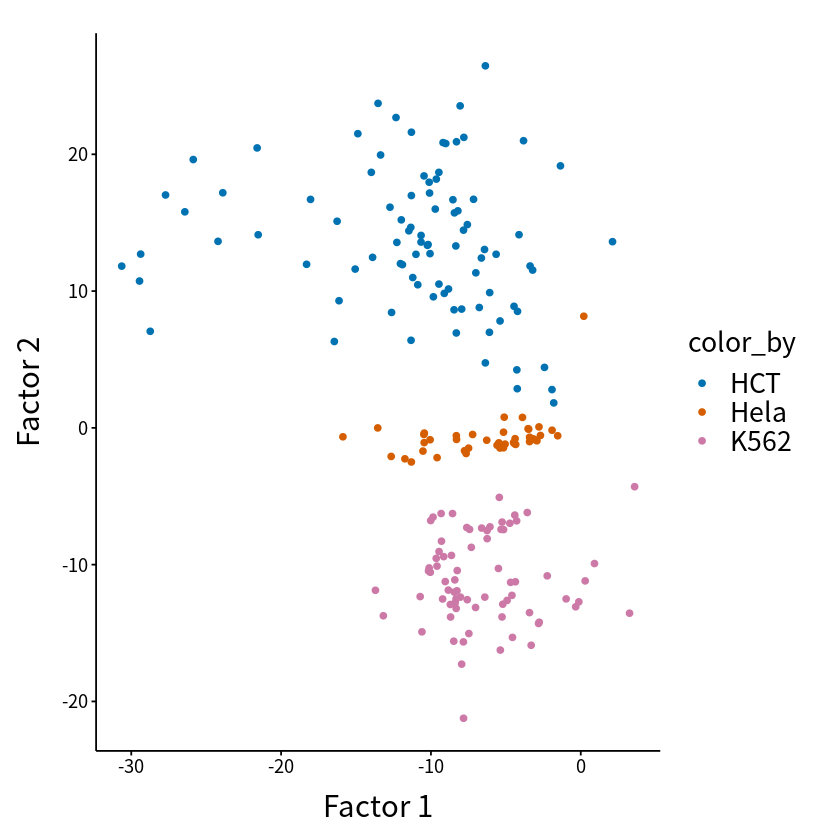

In [20]:
factorization=read.table("../data/single-cell/DAE_FCTAE_EM.txt", sep=" ", header=FALSE)

library("ggplot2")
library("clusterCrit")
#source("runfactorization.R")

# Parameters for the plots
dot_size <- 1.5
dot_alpha <- 1.0
xlabel <- "Factor 1"
ylabel <- "Factor 2"

# Load annotations from the metadata
sample_annot <- metadata[, c("sample.rna", "celltype")]

# Folder for results
results_folder <- "../results_single_cell_DAE_FCTAE_EM/"
# Create output folder
dir.create(results_folder, showWarnings = FALSE)

c_index <- numeric(0)

# Get factorization result
factors <- factorization

# Delete NAs
factors <- factors[!is.na(factors[,1]) & !is.na(factors[,2]), ]
sample_annot <- sample_annot[!is.na(sample_annot[,1]) & !is.na(sample_annot[,2]), ]

# Data to be plotted
df <- data.frame(x =  factors[,1], y = factors[,2], color_by = sample_annot[,2])
# Plot results
p <- ggplot(df, aes_string(x = "x", y = "y")) + 
   geom_point(aes_string(color = "color_by"), size=dot_size, alpha=dot_alpha) + 
   xlab(xlabel) + ylab(ylabel) +
   # scale_shape_manual(values=c(19,1,2:18)[seq_along(unique(shape_by))]) +
   theme(plot.margin = margin(20, 20, 10, 10), 
         axis.text = element_text(size = rel(1), color = "black"), 
         axis.title = element_text(size = 16), 
         axis.title.y = element_text(size = rel(1.1), margin = margin(0, 10, 0, 0)), 
         axis.title.x = element_text(size = rel(1.1), margin = margin(10, 0, 0, 0)), 
         axis.line = element_line(color = "black", size = 0.5), 
         axis.ticks = element_line(color = "black", size = 0.5),
         panel.border = element_blank(), 
         panel.grid.major = element_blank(),
         panel.grid.minor = element_blank(), 
         panel.background = element_blank(),
         legend.key = element_rect(fill = "white"),
         legend.text = element_text(size = 16),
         legend.title = element_text(size =16)
   )
p + scale_color_manual(values=c("#0072B2", "#D55E00", "#CC79A7"))
# Export plot as JPEG image
ggsave(paste0(results_folder, "plot_","DAE_FCTAE_EM",".jpg"))

# Encode cell type annotations by numeric codes
ann <- factor(sample_annot[,2], levels=c("HCT", "Hela", "K562"))
ann <- as.integer(ann)
print(ann)
# Compare factors and annotations
c_index <- c(c_index, intCriteria(as.matrix(factors), as.integer(ann), crit=c("C_index"))$c_index)

# Build output table
report_cindex <- data.frame(method="DAE_FCTAE_EM", cindex=c_index)

# Export results as one tab-separated table
write.table(report_cindex, file = paste0(results_folder, "singlecell_cindex_DAE_FCTAE_EM.txt"), 
            sep="\t", col.names=FALSE, row.names=FALSE, quote=FALSE)

Saving 6.67 x 6.67 in image



  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[112] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[186] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3


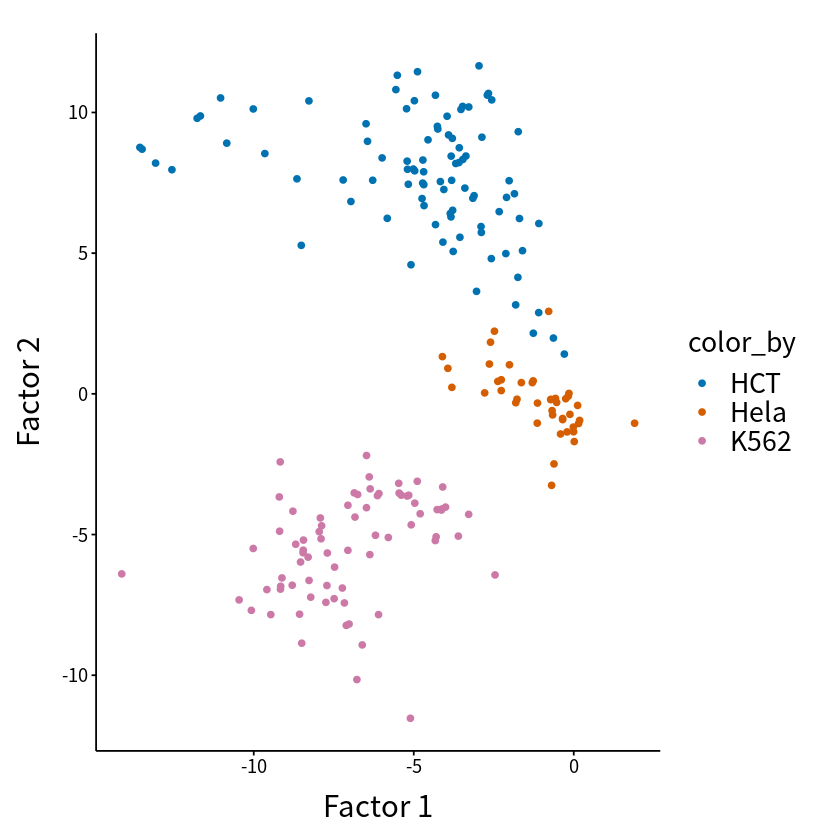

In [21]:
factorization=read.table("../data/single-cell/VAE_FCTAE_EM.txt", sep=" ", header=FALSE)

library("ggplot2")
library("clusterCrit")
#source("runfactorization.R")

# Parameters for the plots
dot_size <- 1.5
dot_alpha <- 1.0
xlabel <- "Factor 1"
ylabel <- "Factor 2"

# Load annotations from the metadata
sample_annot <- metadata[, c("sample.rna", "celltype")]

# Folder for results
results_folder <- "../results_single_cell_VAE_FCTAE_EM/"
# Create output folder
dir.create(results_folder, showWarnings = FALSE)

c_index <- numeric(0)

# Get factorization result
factors <- factorization

# Delete NAs
factors <- factors[!is.na(factors[,1]) & !is.na(factors[,2]), ]
sample_annot <- sample_annot[!is.na(sample_annot[,1]) & !is.na(sample_annot[,2]), ]

# Data to be plotted
df <- data.frame(x =  factors[,1], y = factors[,2], color_by = sample_annot[,2])
# Plot results
p <- ggplot(df, aes_string(x = "x", y = "y")) + 
   geom_point(aes_string(color = "color_by"), size=dot_size, alpha=dot_alpha) + 
   xlab(xlabel) + ylab(ylabel) +
   # scale_shape_manual(values=c(19,1,2:18)[seq_along(unique(shape_by))]) +
   theme(plot.margin = margin(20, 20, 10, 10), 
         axis.text = element_text(size = rel(1), color = "black"), 
         axis.title = element_text(size = 16), 
         axis.title.y = element_text(size = rel(1.1), margin = margin(0, 10, 0, 0)), 
         axis.title.x = element_text(size = rel(1.1), margin = margin(10, 0, 0, 0)), 
         axis.line = element_line(color = "black", size = 0.5), 
         axis.ticks = element_line(color = "black", size = 0.5),
         panel.border = element_blank(), 
         panel.grid.major = element_blank(),
         panel.grid.minor = element_blank(), 
         panel.background = element_blank(),
         legend.key = element_rect(fill = "white"),
         legend.text = element_text(size = 16),
         legend.title = element_text(size =16)
   )
p + scale_color_manual(values=c("#0072B2", "#D55E00", "#CC79A7"))
# Export plot as JPEG image
ggsave(paste0(results_folder, "plot_","VAE_FCTAE_EM",".jpg"))

# Encode cell type annotations by numeric codes
ann <- factor(sample_annot[,2], levels=c("HCT", "Hela", "K562"))
ann <- as.integer(ann)
print(ann)
# Compare factors and annotations
c_index <- c(c_index, intCriteria(as.matrix(factors), as.integer(ann), crit=c("C_index"))$c_index)

# Build output table
report_cindex <- data.frame(method="VAE_FCTAE_EM", cindex=c_index)

# Export results as one tab-separated table
write.table(report_cindex, file = paste0(results_folder, "singlecell_cindex_VAE_FCTAE_EM.txt"), 
            sep="\t", col.names=FALSE, row.names=FALSE, quote=FALSE)

Saving 6.67 x 6.67 in image



  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[112] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[186] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3


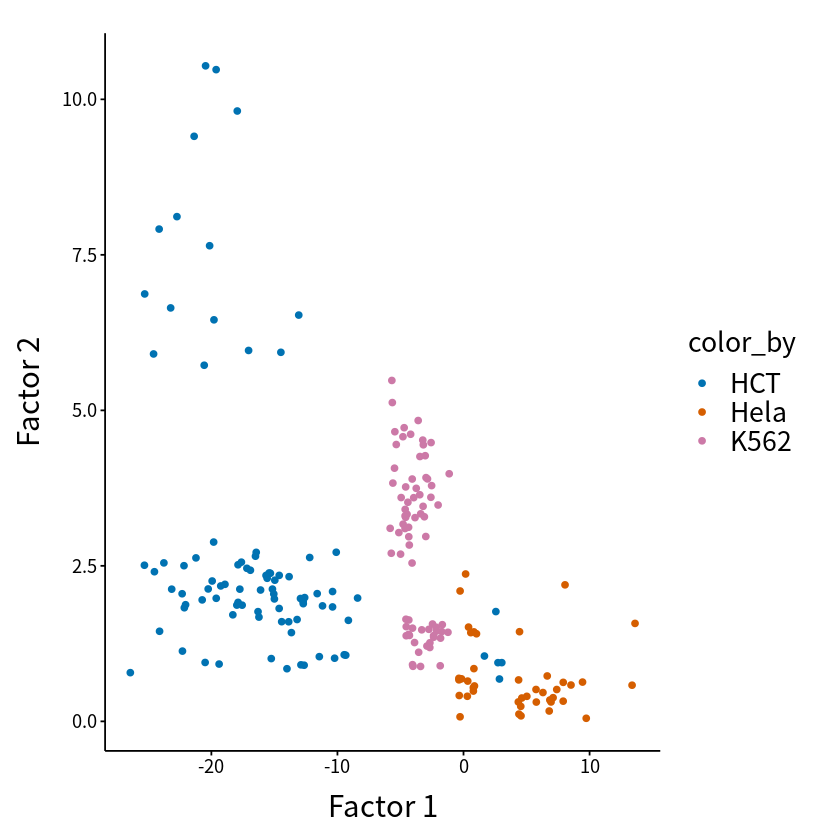

In [22]:
factorization=read.table("../data/single-cell/DAE_FAETC_EM.txt", sep=" ", header=FALSE)

library("ggplot2")
library("clusterCrit")
#source("runfactorization.R")

# Parameters for the plots
dot_size <- 1.5
dot_alpha <- 1.0
xlabel <- "Factor 1"
ylabel <- "Factor 2"

# Load annotations from the metadata
sample_annot <- metadata[, c("sample.rna", "celltype")]

# Folder for results
results_folder <- "../results_single_cell_DAE_FAETC_EM/"
# Create output folder
dir.create(results_folder, showWarnings = FALSE)

c_index <- numeric(0)

# Get factorization result
factors <- factorization

# Delete NAs
factors <- factors[!is.na(factors[,1]) & !is.na(factors[,2]), ]
sample_annot <- sample_annot[!is.na(sample_annot[,1]) & !is.na(sample_annot[,2]), ]

# Data to be plotted
df <- data.frame(x =  factors[,1], y = factors[,2], color_by = sample_annot[,2])
# Plot results
p <- ggplot(df, aes_string(x = "x", y = "y")) + 
   geom_point(aes_string(color = "color_by"), size=dot_size, alpha=dot_alpha) + 
   xlab(xlabel) + ylab(ylabel) +
   # scale_shape_manual(values=c(19,1,2:18)[seq_along(unique(shape_by))]) +
   theme(plot.margin = margin(20, 20, 10, 10), 
         axis.text = element_text(size = rel(1), color = "black"), 
         axis.title = element_text(size = 16), 
         axis.title.y = element_text(size = rel(1.1), margin = margin(0, 10, 0, 0)), 
         axis.title.x = element_text(size = rel(1.1), margin = margin(10, 0, 0, 0)), 
         axis.line = element_line(color = "black", size = 0.5), 
         axis.ticks = element_line(color = "black", size = 0.5),
         panel.border = element_blank(), 
         panel.grid.major = element_blank(),
         panel.grid.minor = element_blank(), 
         panel.background = element_blank(),
         legend.key = element_rect(fill = "white"),
         legend.text = element_text(size = 16),
         legend.title = element_text(size =16)
   )
p + scale_color_manual(values=c("#0072B2", "#D55E00", "#CC79A7"))
# Export plot as JPEG image
ggsave(paste0(results_folder, "plot_","DAE_FAETC_EM",".jpg"))

# Encode cell type annotations by numeric codes
ann <- factor(sample_annot[,2], levels=c("HCT", "Hela", "K562"))
ann <- as.integer(ann)
print(ann)
# Compare factors and annotations
c_index <- c(c_index, intCriteria(as.matrix(factors), as.integer(ann), crit=c("C_index"))$c_index)

# Build output table
report_cindex <- data.frame(method="DAE_FAETC_EM", cindex=c_index)

# Export results as one tab-separated table
write.table(report_cindex, file = paste0(results_folder, "singlecell_cindex_DAE_FAETC_EM.txt"), 
            sep="\t", col.names=FALSE, row.names=FALSE, quote=FALSE)

Saving 6.67 x 6.67 in image



  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[112] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[186] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3


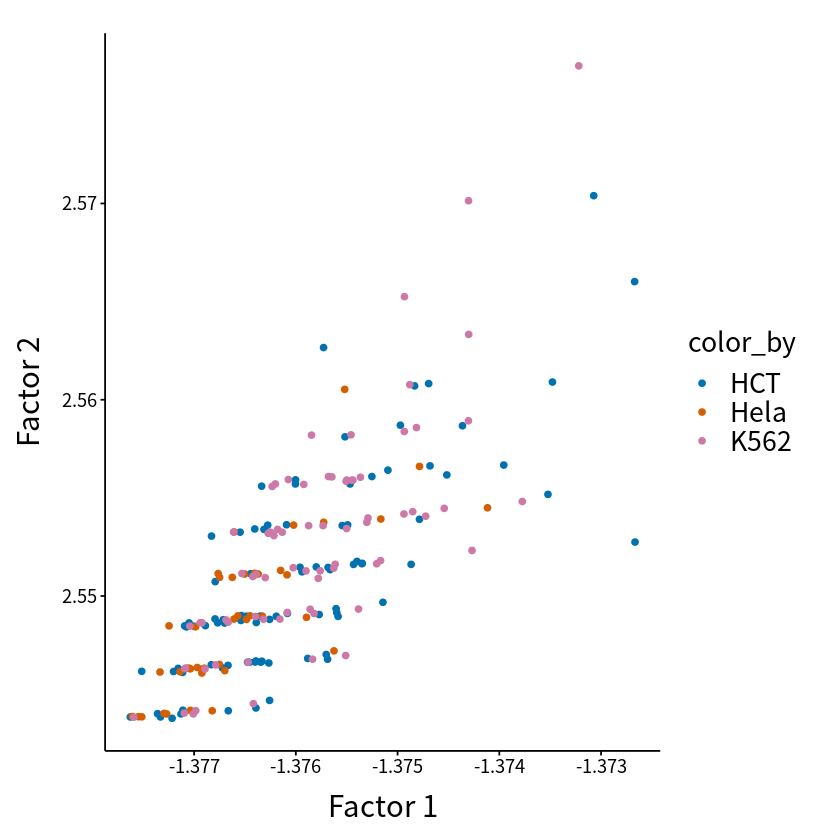

In [5]:
factorization=read.table("../data/single-cell/LSTMVAE_FCTAE_EM.txt", sep=" ", header=FALSE)

library("ggplot2")
library("clusterCrit")
#source("runfactorization.R")

# Parameters for the plots
dot_size <- 1.5
dot_alpha <- 1.0
xlabel <- "Factor 1"
ylabel <- "Factor 2"

# Load annotations from the metadata
sample_annot <- metadata[, c("sample.rna", "celltype")]

# Folder for results
results_folder <- "../results_single_cell_LSTMVAE_FCTAE_EM/"
# Create output folder
dir.create(results_folder, showWarnings = FALSE)

c_index <- numeric(0)

# Get factorization result
factors <- factorization

# Delete NAs
factors <- factors[!is.na(factors[,1]) & !is.na(factors[,2]), ]
sample_annot <- sample_annot[!is.na(sample_annot[,1]) & !is.na(sample_annot[,2]), ]

# Data to be plotted
df <- data.frame(x =  factors[,1], y = factors[,2], color_by = sample_annot[,2])
# Plot results
p <- ggplot(df, aes_string(x = "x", y = "y")) + 
   geom_point(aes_string(color = "color_by"), size=dot_size, alpha=dot_alpha) + 
   xlab(xlabel) + ylab(ylabel) +
   # scale_shape_manual(values=c(19,1,2:18)[seq_along(unique(shape_by))]) +
   theme(plot.margin = margin(20, 20, 10, 10), 
         axis.text = element_text(size = rel(1), color = "black"), 
         axis.title = element_text(size = 16), 
         axis.title.y = element_text(size = rel(1.1), margin = margin(0, 10, 0, 0)), 
         axis.title.x = element_text(size = rel(1.1), margin = margin(10, 0, 0, 0)), 
         axis.line = element_line(color = "black", size = 0.5), 
         axis.ticks = element_line(color = "black", size = 0.5),
         panel.border = element_blank(), 
         panel.grid.major = element_blank(),
         panel.grid.minor = element_blank(), 
         panel.background = element_blank(),
         legend.key = element_rect(fill = "white"),
         legend.text = element_text(size = 16),
         legend.title = element_text(size =16)
   )
p + scale_color_manual(values=c("#0072B2", "#D55E00", "#CC79A7"))
# Export plot as JPEG image
ggsave(paste0(results_folder, "plot_","LSTMVAE_FCTAE_EM",".jpg"))

# Encode cell type annotations by numeric codes
ann <- factor(sample_annot[,2], levels=c("HCT", "Hela", "K562"))
ann <- as.integer(ann)
print(ann)
# Compare factors and annotations
c_index <- c(c_index, intCriteria(as.matrix(factors), as.integer(ann), crit=c("C_index"))$c_index)

# Build output table
report_cindex <- data.frame(method="LSTMVAE_FCTAE_EM", cindex=c_index)

# Export results as one tab-separated table
write.table(report_cindex, file = paste0(results_folder, "singlecell_cindex_LSTMVAE_FCTAE_EM.txt"), 
            sep="\t", col.names=FALSE, row.names=FALSE, quote=FALSE)

Saving 6.67 x 6.67 in image



  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[112] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[186] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3


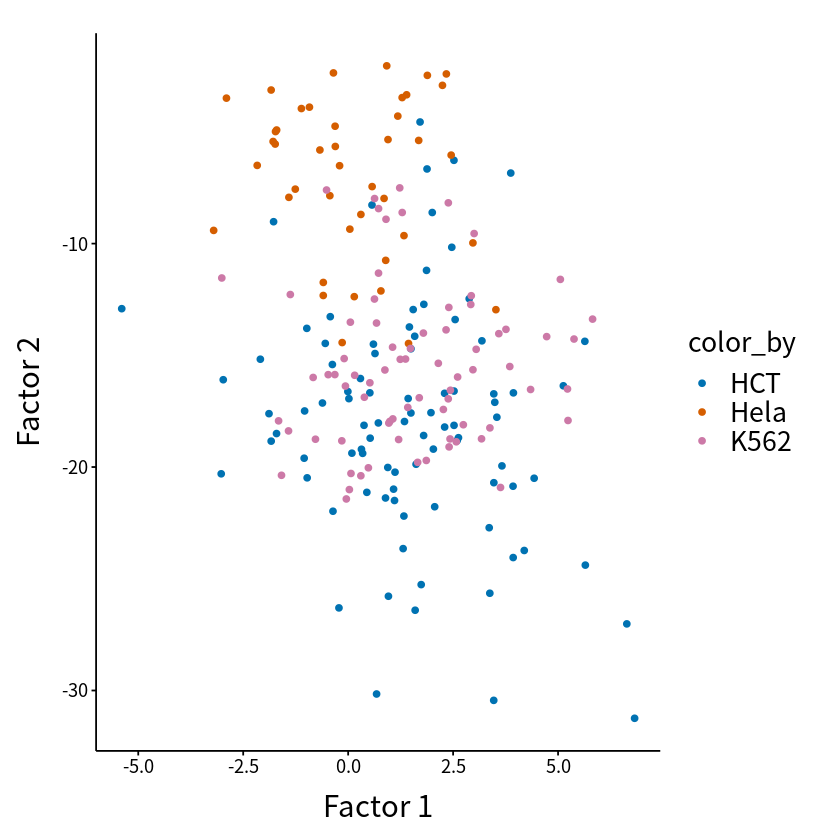

In [6]:
factorization=read.table("../data/single-cell/SVAE_FCTAE_EM.txt", sep=" ", header=FALSE)

library("ggplot2")
library("clusterCrit")
#source("runfactorization.R")

# Parameters for the plots
dot_size <- 1.5
dot_alpha <- 1.0
xlabel <- "Factor 1"
ylabel <- "Factor 2"

# Load annotations from the metadata
sample_annot <- metadata[, c("sample.rna", "celltype")]

# Folder for results
results_folder <- "../results_single_cell_SVAE_FCTAE_EM/"
# Create output folder
dir.create(results_folder, showWarnings = FALSE)

c_index <- numeric(0)

# Get factorization result
factors <- factorization

# Delete NAs
factors <- factors[!is.na(factors[,1]) & !is.na(factors[,2]), ]
sample_annot <- sample_annot[!is.na(sample_annot[,1]) & !is.na(sample_annot[,2]), ]

# Data to be plotted
df <- data.frame(x =  factors[,1], y = factors[,2], color_by = sample_annot[,2])
# Plot results
p <- ggplot(df, aes_string(x = "x", y = "y")) + 
   geom_point(aes_string(color = "color_by"), size=dot_size, alpha=dot_alpha) + 
   xlab(xlabel) + ylab(ylabel) +
   # scale_shape_manual(values=c(19,1,2:18)[seq_along(unique(shape_by))]) +
   theme(plot.margin = margin(20, 20, 10, 10), 
         axis.text = element_text(size = rel(1), color = "black"), 
         axis.title = element_text(size = 16), 
         axis.title.y = element_text(size = rel(1.1), margin = margin(0, 10, 0, 0)), 
         axis.title.x = element_text(size = rel(1.1), margin = margin(10, 0, 0, 0)), 
         axis.line = element_line(color = "black", size = 0.5), 
         axis.ticks = element_line(color = "black", size = 0.5),
         panel.border = element_blank(), 
         panel.grid.major = element_blank(),
         panel.grid.minor = element_blank(), 
         panel.background = element_blank(),
         legend.key = element_rect(fill = "white"),
         legend.text = element_text(size = 16),
         legend.title = element_text(size =16)
   )
p + scale_color_manual(values=c("#0072B2", "#D55E00", "#CC79A7"))
# Export plot as JPEG image
ggsave(paste0(results_folder, "plot_","SVAE_FCTAE_EM",".jpg"))

# Encode cell type annotations by numeric codes
ann <- factor(sample_annot[,2], levels=c("HCT", "Hela", "K562"))
ann <- as.integer(ann)
print(ann)
# Compare factors and annotations
c_index <- c(c_index, intCriteria(as.matrix(factors), as.integer(ann), crit=c("C_index"))$c_index)

# Build output table
report_cindex <- data.frame(method="SVAE_FCTAE_EM", cindex=c_index)

# Export results as one tab-separated table
write.table(report_cindex, file = paste0(results_folder, "singlecell_cindex_SVAE_FCTAE_EM.txt"), 
            sep="\t", col.names=FALSE, row.names=FALSE, quote=FALSE)

Saving 6.67 x 6.67 in image



  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[112] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[186] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3


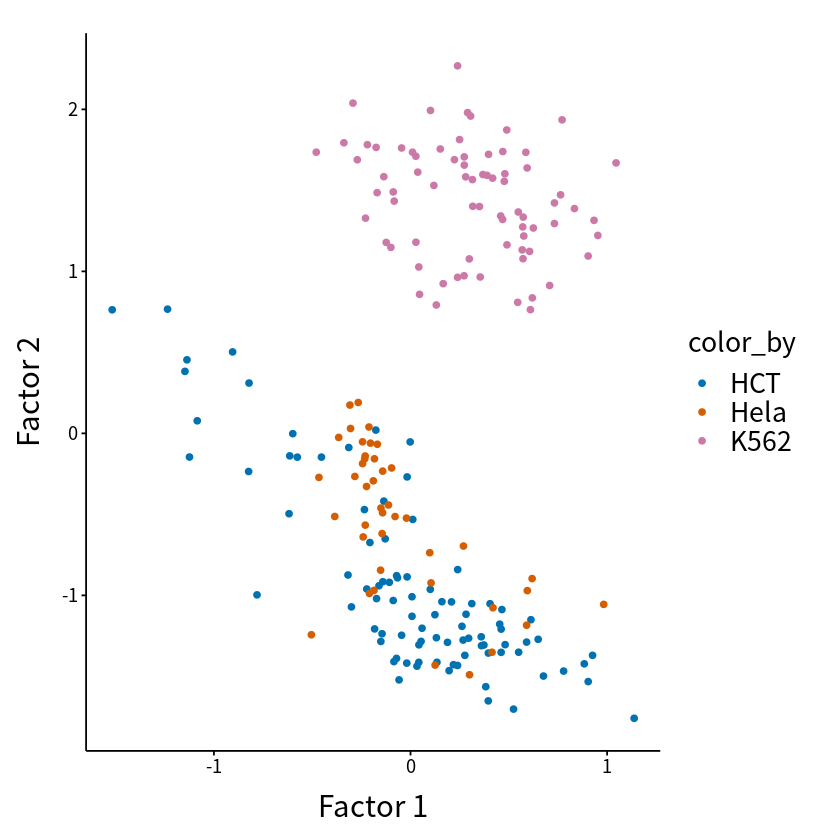

In [7]:
factorization=read.table("../data/single-cell/MMDVAE_EM.txt", sep=" ", header=FALSE)

library("ggplot2")
library("clusterCrit")
#source("runfactorization.R")

# Parameters for the plots
dot_size <- 1.5
dot_alpha <- 1.0
xlabel <- "Factor 1"
ylabel <- "Factor 2"

# Load annotations from the metadata
sample_annot <- metadata[, c("sample.rna", "celltype")]

# Folder for results
results_folder <- "../results_single_cell_MMDVAE_EM/"
# Create output folder
dir.create(results_folder, showWarnings = FALSE)

c_index <- numeric(0)

# Get factorization result
factors <- factorization

# Delete NAs
factors <- factors[!is.na(factors[,1]) & !is.na(factors[,2]), ]
sample_annot <- sample_annot[!is.na(sample_annot[,1]) & !is.na(sample_annot[,2]), ]

# Data to be plotted
df <- data.frame(x =  factors[,1], y = factors[,2], color_by = sample_annot[,2])
# Plot results
p <- ggplot(df, aes_string(x = "x", y = "y")) + 
   geom_point(aes_string(color = "color_by"), size=dot_size, alpha=dot_alpha) + 
   xlab(xlabel) + ylab(ylabel) +
   # scale_shape_manual(values=c(19,1,2:18)[seq_along(unique(shape_by))]) +
   theme(plot.margin = margin(20, 20, 10, 10), 
         axis.text = element_text(size = rel(1), color = "black"), 
         axis.title = element_text(size = 16), 
         axis.title.y = element_text(size = rel(1.1), margin = margin(0, 10, 0, 0)), 
         axis.title.x = element_text(size = rel(1.1), margin = margin(10, 0, 0, 0)), 
         axis.line = element_line(color = "black", size = 0.5), 
         axis.ticks = element_line(color = "black", size = 0.5),
         panel.border = element_blank(), 
         panel.grid.major = element_blank(),
         panel.grid.minor = element_blank(), 
         panel.background = element_blank(),
         legend.key = element_rect(fill = "white"),
         legend.text = element_text(size = 16),
         legend.title = element_text(size =16)
   )
p + scale_color_manual(values=c("#0072B2", "#D55E00", "#CC79A7"))
# Export plot as JPEG image
ggsave(paste0(results_folder, "plot_","MMDVAE_EM",".jpg"))

# Encode cell type annotations by numeric codes
ann <- factor(sample_annot[,2], levels=c("HCT", "Hela", "K562"))
ann <- as.integer(ann)
print(ann)
# Compare factors and annotations
c_index <- c(c_index, intCriteria(as.matrix(factors), as.integer(ann), crit=c("C_index"))$c_index)

# Build output table
report_cindex <- data.frame(method="MMDVAE_EM", cindex=c_index)

# Export results as one tab-separated table
write.table(report_cindex, file = paste0(results_folder, "singlecell_cindex_MMDVAE_EM.txt"), 
            sep="\t", col.names=FALSE, row.names=FALSE, quote=FALSE)